# Fetch ML OA
Predict number of receipts for a given future month.

I know this is super late. I'm grateful if you're looking at this. Thank you for the opportunity!

## Load Data

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
receipts_2021_df = pd.read_csv("daily_data.csv")
receipts_2021_df.head()

,# Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


## Exploration and Prep

In [27]:
receipts_2021_df['# Date'] = pd.to_datetime(receipts_2021_df['# Date'], format='%Y-%m-%d')
receipts_2021_df["Month"] = receipts_2021_df["# Date"].dt.month
receipts_2021_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   # Date         365 non-null    datetime64[ns]
 1   Receipt_Count  365 non-null    int64         
 2   Month          365 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(1)
memory usage: 7.3 KB


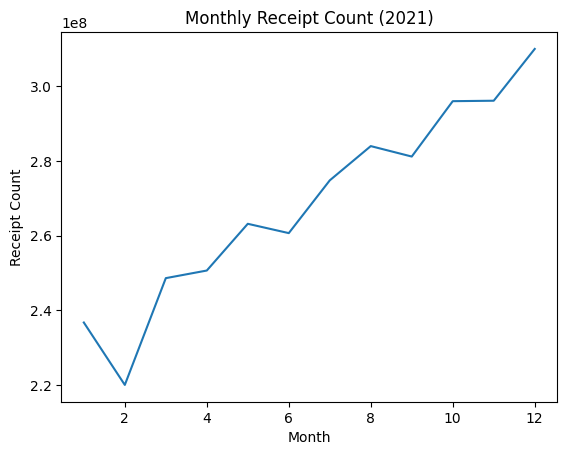

In [28]:
monthly_receipts = receipts_2021_df.groupby("Month")["Receipt_Count"].sum()

plt.plot(monthly_receipts)
plt.xlabel('Month')
plt.ylabel('Receipt Count')
plt.title('Monthly Receipt Count (2021)')
plt.show()

Notes:
- Relationship looks very linear. Models to try: Linear Regression with ridge penalty, and NN.
- Not enough data to create a validation/testing set, so we will test compared to the real 2021 values.

## Linear Regression with Ridge Penalty (Gradient Descent)

The ridge penalty is used in linear regression to prevent overfitting by adding a regularization term to the loss function. It helps to reduce the impact of large coefficients in the model, which can lead to overfitting.  

My code from a class assignment.

In [29]:
def MSE(y_values, yhat):
    return np.mean((y_values - yhat) ** 2)


def r_squared(y_values, yhat):
    ss_residual = np.sum((y_values - yhat) ** 2)
    ss_total = np.sum((y_values - np.mean(y_values)) ** 2)
    return 1 - (ss_residual / ss_total)


def adjusted_r_squared(y_values, yhat):
    n = len(y_values)
    p = 1 # only one predictor is this OA
    r2 = r_squared(y_values, yhat)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)


def AIC(y_values, yhat):
    n = len(y_values)
    p = 1
    mse = MSE(y_values, yhat)
    aic = n * np.log(mse / n) + 2 * p
    return aic


def BIC(y_values, yhat):
    n = len(y_values)
    p = 1
    mse = MSE(y_values, yhat)
    bic = n * np.log(mse / n) + p * np.log(n)
    return bic

In [30]:
def predict(B, X):
    return np.sum(B * X, axis=1)


def ridge_gradient(X, y, B, lam):
    p = predict(B, X)

    t0 = (y * (1 - p))[:, np.newaxis] * X
    t1 = ((1 - y) * p)[:, np.newaxis] * X
    gradient = -1 * np.sum(t0 , axis=0) + np.sum(t1, axis=0)

    ridge_term = np.squeeze(2 * lam * B)
    gradient += ridge_term

    return gradient


def fit_linear_regression_ridge(X, y, lam, eta=0.001, decay_factor=1, max_iter=1e6):
    B = np.zeros(len(X[0]))
    
    i = 0
    while i < max_iter:
        gradient = ridge_gradient(X, y, B, lam)
        B_new = -eta * gradient + B
        eta = eta * decay_factor

        if np.sum(B - B_new) / len(B) < 0.01: # stopping condisiton
            return B_new

        B = B_new
        i += 1

    return B


def test_lambdas(X_train, y_train, lambdas, metric_f):
    results = []
    for lam in lambdas:
        B = fit_linear_regression_ridge(X_train, y_train, lam)
        metric = metric_f(y_train, predict(B, X_train))
        results.append((B, metric))
    return results


In [31]:
X_train = np.expand_dims(monthly_receipts.index.values, axis=1)
X_train = np.hstack((np.ones_like(X_train), X_train)) # intercept

y_train = np.array(monthly_receipts.values)

In [32]:
test_lambdas(X_train, y_train, [0.01, 0.1, 1, 5, 10, 20, 30, 50, 100, 1000], r_squared)

[(array([ 3221696.609, 21966174.677]), -26.03632234440216),
 (array([ 3221696.609, 21966174.677]), -26.03632234440216),
 (array([ 3221696.609, 21966174.677]), -26.03632234440216),
 (array([ 3221696.609, 21966174.677]), -26.03632234440216),
 (array([ 3221696.609, 21966174.677]), -26.03632234440216),
 (array([ 3221696.609, 21966174.677]), -26.03632234440216),
 (array([ 3221696.609, 21966174.677]), -26.03632234440216),
 (array([ 3221696.609, 21966174.677]), -26.03632234440216),
 (array([ 3221696.609, 21966174.677]), -26.03632234440216),
 (array([ 3221696.609, 21966174.677]), -26.03632234440216)]

In [33]:
lr_yhat = predict([322169.6609, 2196617.4677], X_train)
lr_yhat

array([ 2518787.1286,  4715404.5963,  6912022.064 ,  9108639.5317,
       11305256.9994, 13501874.4671, 15698491.9348, 17895109.4025,
       20091726.8702, 22288344.3379, 24484961.8056, 26681579.2733])

Notes:
- Lambda has no effect?
- Eta (learning rate) is very influential.

## PyTorch Neural Net Model

In [34]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [35]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


def train_model(model, train_loader, criterion, optimizer, num_epochs):
    loss = 0.0
    for _ in tqdm(range(num_epochs)):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss = running_loss
    print(f"Final Loss: {running_loss/len(train_loader)}")

In [36]:
X_train_nn = torch.Tensor(monthly_receipts.index.values)
y_train_nn = torch.Tensor(monthly_receipts.values)

train_dataset = TensorDataset(X_train_nn, y_train_nn)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [38]:
model = SimpleClassifier(input_size=12, hidden_size=100, output_size=12)
criterion = nn.MSELoss() # no concerns about outliers so MSE is reasonable
optimizer = optim.Adam(model.parameters(), lr=0.1)

train_model(model, train_loader, criterion, optimizer, num_epochs=100000)

100%|██████████| 100000/100000 [00:43<00:00, 2301.72it/s]

Final Loss: 45377147371520.0


In [39]:
nn_yhat = model(X_train_nn)
nn_yhat = nn_yhat.detach().numpy()
nn_yhat

array([2.2877776e+08, 2.3641480e+08, 2.4394035e+08, 2.5053752e+08,
       2.5778395e+08, 2.6495542e+08, 2.7255312e+08, 2.7867651e+08,
       2.8711296e+08, 2.9291920e+08, 2.9978365e+08, 3.0807402e+08],
      dtype=float32)

Notes:
- Seems overly complicated for what looks like a linear problem.


## Evaluation

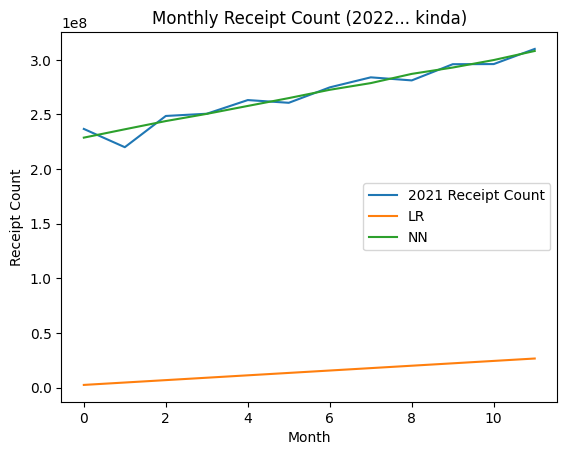

In [41]:
plt.plot(y_train, label='2021 Receipt Count')
plt.plot(lr_yhat, label='LR')
plt.plot(nn_yhat, label='NN')
plt.xlabel('Month')
plt.ylabel('Receipt Count')
plt.title('Monthly Receipt Count (2022... kinda)')
plt.legend()
plt.show()

Notes:
- Something is wrong with my Linear Regression model. Not sure why the interccept doesn't want to budge but the slope looks spot on.
- NN looks fantastic.
- In a realistic scenario, I would hopefully have more data so I don't test on the data I trained on. However, I think this is okay in this case as we have so limited data.

## Interaction

In [44]:
def predict_receipts_by_month(outputs, month):
    month_to_number = {
        'january': 1,
        'february': 2,
        'march': 3,
        'april': 4,
        'may': 5,
        'june': 6,
        'july': 7,
        'august': 8,
        'september': 9,
        'october': 10,
        'november': 11,
        'december': 12
    }
    month_number = month_to_number.get(month.lower(), None)
    if month_number is None:
        print("Invalid month")
        return
    return outputs[month_number]

outputs = [2.2877776e+08, 2.3641480e+08, 2.4394035e+08, 2.5053752e+08,
       2.5778395e+08, 2.6495542e+08, 2.7255312e+08, 2.7867651e+08,
       2.8711296e+08, 2.9291920e+08, 2.9978365e+08, 3.0807402e+08]

# CHANGE THE MONTH HERE TO SEE PREDICTION FOR 2022 :)
predict_receipts_by_month(outputs, 'february')

243940350.0

Since we only have one year of data, we cannot predict anything more than month as we don't have any information about trends across years. So, this is the best we can do. The benefit of this is no recalculations but it definitely can be improved with more data.